## Practice using k-means
Using scikit-learn package and Palmer penguins data.

scikit-learn documentation and demos here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Metric of model performance: silhouette score: the ratio between the mean difference within each cluster and mean distance to the nearest cluster (how much variability is there within a cluster vs. between clusters?)

### Load packages

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
import xarray as xr

### packages for scikit-learn
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans ### for kmeans clustering
from sklearn.decomposition import PCA ### for doing PCA
from sklearn.metrics import silhouette_score ### calculate silhouette score

### import toy data
import seaborn as sns

### Load data

In [ ]:
### load from seaborn
penguins_df = sns.load_dataset("penguins")

### see what it looks like
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


Looks like we have the species, island, and sex as categorical variables, and then 4 continuous variables for each individual.

We'll play around with predicting the species from the other variables. In your assignment, you'll be predicting land cover from other variables -- here, we have the advantage that we actually know what species each individual is; you won't have the actual land cover data for your data. 

BUT we have an issue: there are NaN values in the data, and k-means will not like that. Let's re-import it without the NaN values.

In [13]:
### load from seaborn but drop NA rows
penguins_df = sns.load_dataset("penguins").dropna()
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


Looks like we lost 11 rows, but we got rid of the NA values

### Initial data visualization
Play around with visualizing the data to see what it looks like

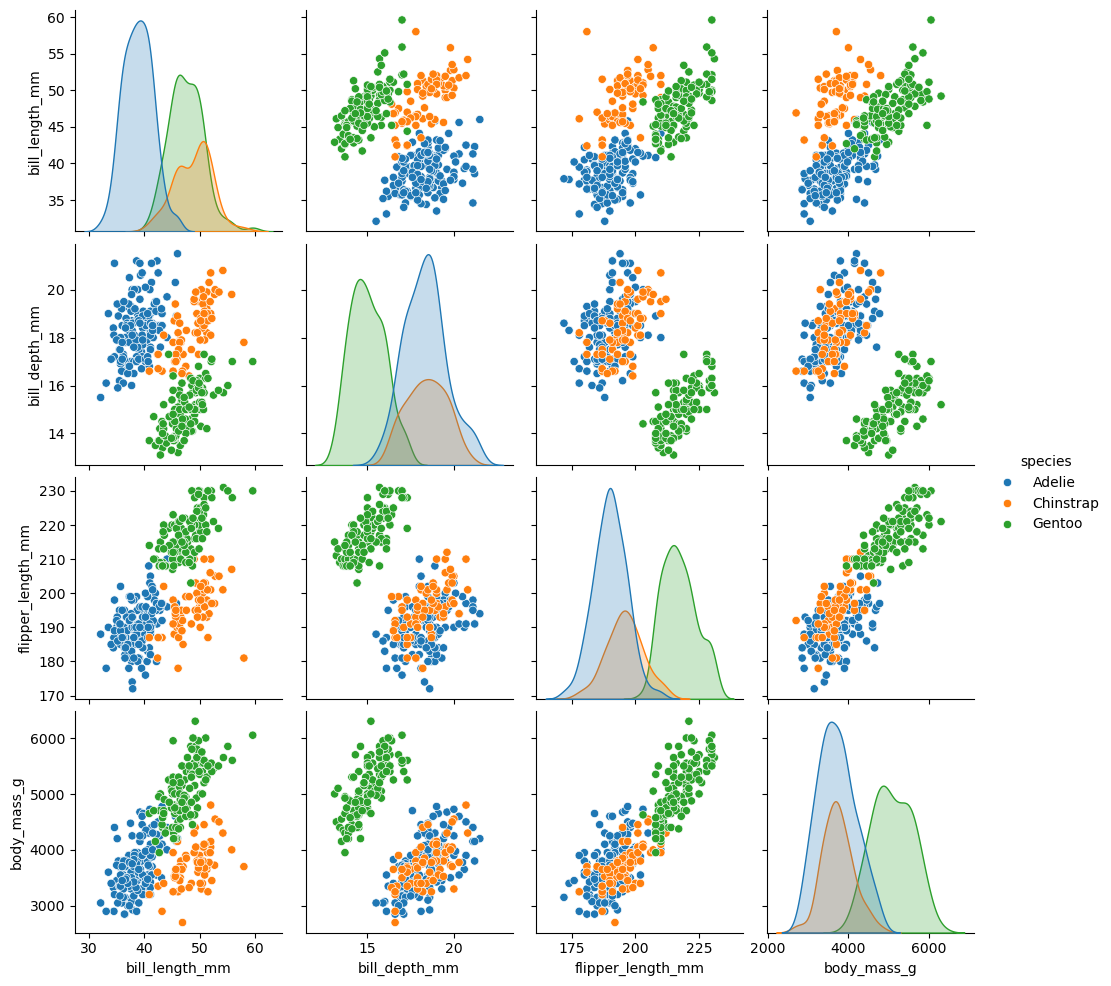

In [14]:
### how many species are there?
np.unique(penguins_df.species) 
### 3 total

### make a pairplot to look at continuous variables
sns.pairplot(penguins_df, hue = "species")

We can see that some of the variables are correlated, and some also seem to be bimodal -- we might have some success with clustering on these variables! For example, bill length and flipper length

### Define a model
We want to minimize the inertia (within-cluster variability)

Because we randomly initialize the algorithm, we might not get the absolute best clusters (k-means runs multiple times to explore different possible results). We also don't have a guarantee that the clusters generated by k-means will map on to the actual categories we're interested in.

In [ ]:
### make a k-means model with 3 clusters (here, the hyperparameter k = 3)
k_means = KMeans(n_clusters = 3)

### fit the model to the data (specify that we want the numerical variables)
k_means.fit(penguins_df[['bill_length_mm',
                         'bill_depth_mm',
                         'flipper_length_mm',
                         'body_mass_g']])

### add the cluster labels to the dataframe
penguins_df['k_means_labels'] = k_means.labels_

### check it out
penguins_df

c:\Users\kjsie\anaconda3\envs\earth-analytics-python\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,k_means_labels
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0
...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,2
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,2
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,1
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,1


We can see the k-means labels in the last column of the dataframe now. When you shape data and add the cluster labels back in, there can be issues where the rows don't line up.

### Visualize clusters

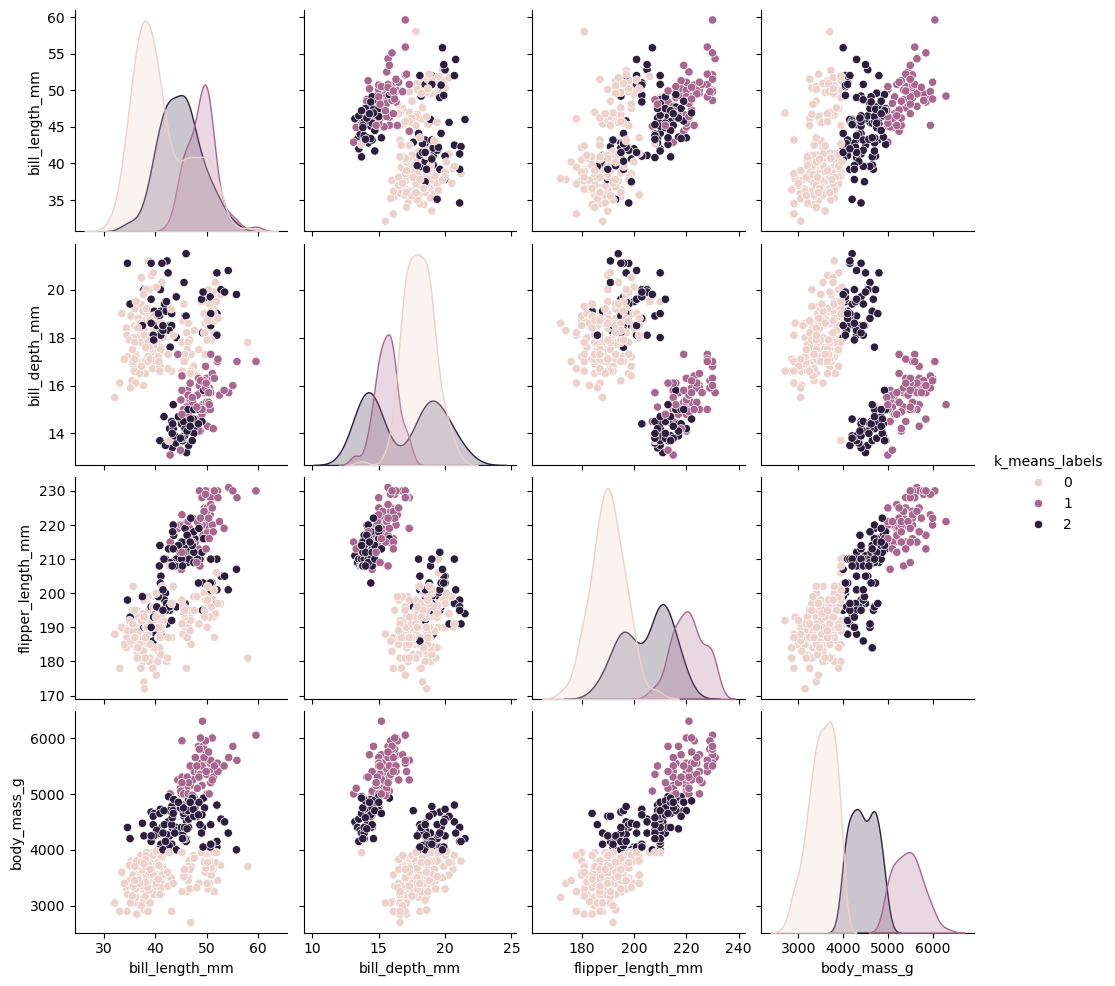

In [16]:
### use pairplots again
sns.pairplot(penguins_df, hue = "k_means_labels")

These clusters aren't lining up exactly with the species breakdown. For example, look at bill depth x body mass: cluster 2 is spanning a big gap.

Even if we didn't know the species a priori, we could still see that some of the clusters aren't getting picked out.

#### Try clustering on different variables
We can limit ourselves to variables that have clearer clusters in the pairplots.

In [31]:
### make a k-means model with 3 clusters (here, the hyperparameter k = 3)
k_means_2 = KMeans(n_clusters = 3)

### fit the model to the data (specify which variables we want)
k_means_2.fit(penguins_df[['bill_length_mm',
                         'bill_depth_mm',
                         'flipper_length_mm']])

### add the cluster labels to the dataframe
penguins_df['k_means_labels_2'] = k_means_2.labels_

### check it out
penguins_df

c:\Users\kjsie\anaconda3\envs\earth-analytics-python\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,k_means_labels,k_means_labels_2,component,k_means_labels_pca
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0,1,3752.419687,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0,1,3802.492555,1
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0,2,3252.700084,1
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0,1,3452.628958,1
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0,1,3652.567458,1
...,...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,2,0,4927.813459,0
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,2,0,4852.835669,0
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,1,0,5752.843115,0
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,1,0,5202.739660,0


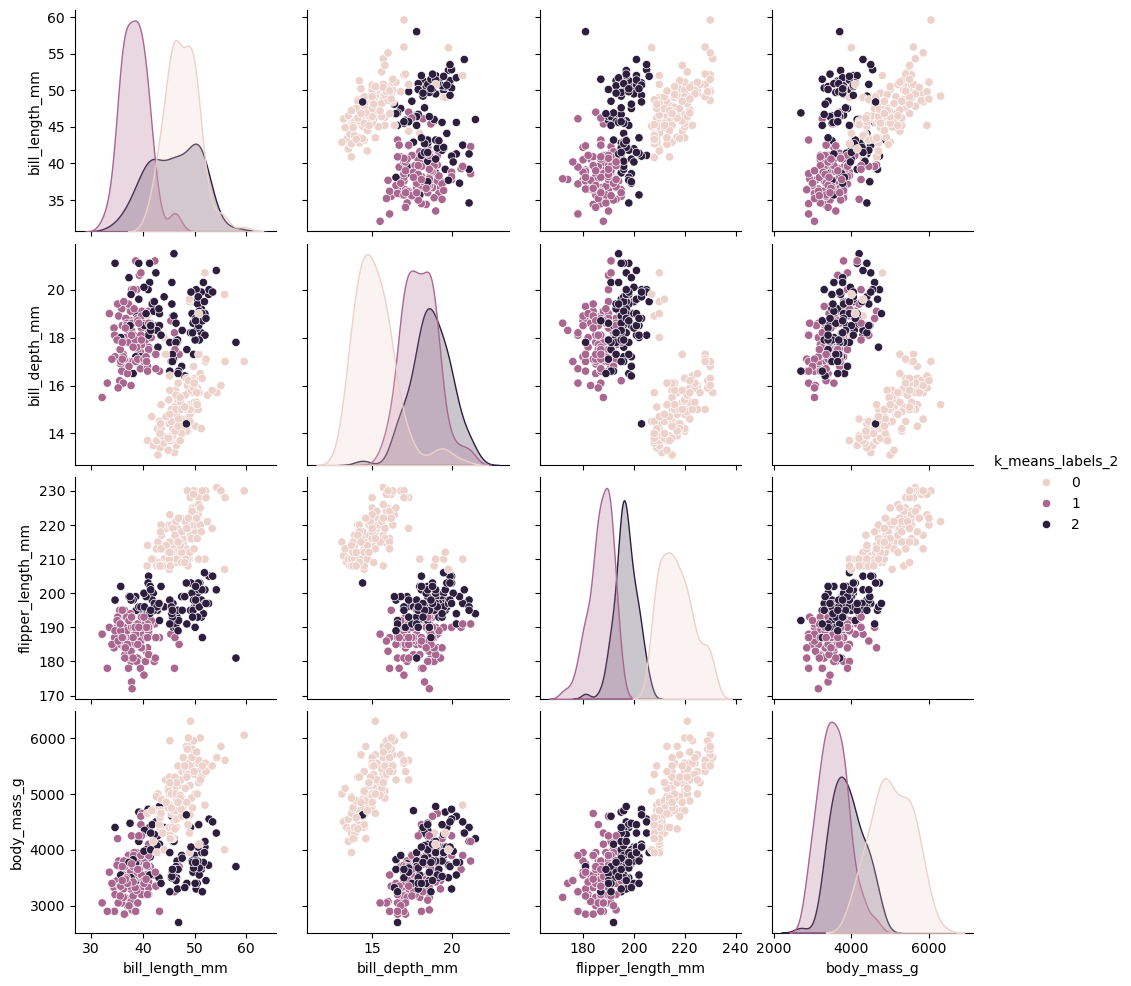

In [32]:
### visualize
sns.pairplot(penguins_df, 
             hue = "k_means_labels_2",
             vars = [
                 'bill_length_mm',
                 'bill_depth_mm',
                 'flipper_length_mm',
                 'body_mass_g'
                 ]
                 )

These clusters look better than when we had all 4 variables. And even though we didn't include body mass in the model, it looks like the clusters map onto the body mass pretty well. 

## Principal components analysis
Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Not required for your multispectral data, but could be useful

In [25]:
### run PCA
### n_components: we tell it how many components to identify (pull out the n most important components)
### if we don't set n_components, it will keep all the components
pca = PCA()

### fit the PCA to the data (specify which variables we want)
pca.fit(penguins_df[['bill_length_mm',
                         'bill_depth_mm',
                         'flipper_length_mm',
                         'body_mass_g']])

### check out the components -- this will spit out the coefficients for the linear combinations of the variables
pca.components_

array([[ 4.00316167e-03, -1.15432728e-03,  1.51945474e-02,
         9.99875876e-01],
       [ 3.19277728e-01, -8.68475312e-02,  9.43542375e-01,
        -1.57170210e-02],
       [ 9.41264749e-01,  1.44494794e-01, -3.05189864e-01,
         1.03610977e-03],
       [-1.09847074e-01,  9.85686273e-01,  1.27890806e-01,
        -3.65748162e-04]])

In [26]:
### check out the variation explained by the PCAs
pca.explained_variance_ratio_

array([9.99893229e-01, 7.82232504e-05, 2.49073610e-05, 3.63992867e-06])

The first component explains 99.99% of the variance! So we probably don't even need the other components

#### Add PCA to the dataframe

In [28]:
### extract the first PCA component
b = pca.components_[0]

### make column in penguins df for component
penguins_df['component'] = (

    ### multiply the original variables by their weight in the first component
    penguins_df[['bill_length_mm']].values * b[0] 
    + penguins_df[['bill_depth_mm']].values * b[1]
    + penguins_df[['flipper_length_mm']].values * b[2]
    + penguins_df[['body_mass_g']].values * b[3]
)

### check it out
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,k_means_labels,k_means_labels_2,component
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0,0,3752.419687
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0,0,3802.492555
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0,0,3252.700084
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0,0,3452.628958
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0,0,3652.567458
...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,2,2,4927.813459
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,2,2,4852.835669
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,1,1,5752.843115
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,1,1,5202.739660


## Cluster on the principal component

In [34]:
### make a k-means model with 3 clusters (here, the hyperparameter k = 3
k_means_pca = KMeans(n_clusters = 3)

### fit the model to just the first principal component
k_means_pca.fit(penguins_df[['component']])

### add the cluster labels to the dataframe
penguins_df['k_means_labels_pca'] = k_means_pca.labels_

### check it out
penguins_df

c:\Users\kjsie\anaconda3\envs\earth-analytics-python\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,k_means_labels,k_means_labels_2,component,k_means_labels_pca
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0,1,3752.419687,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0,1,3802.492555,1
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0,2,3252.700084,1
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0,1,3452.628958,1
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0,1,3652.567458,1
...,...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,2,0,4927.813459,2
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,2,0,4852.835669,0
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,1,0,5752.843115,2
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,1,0,5202.739660,2


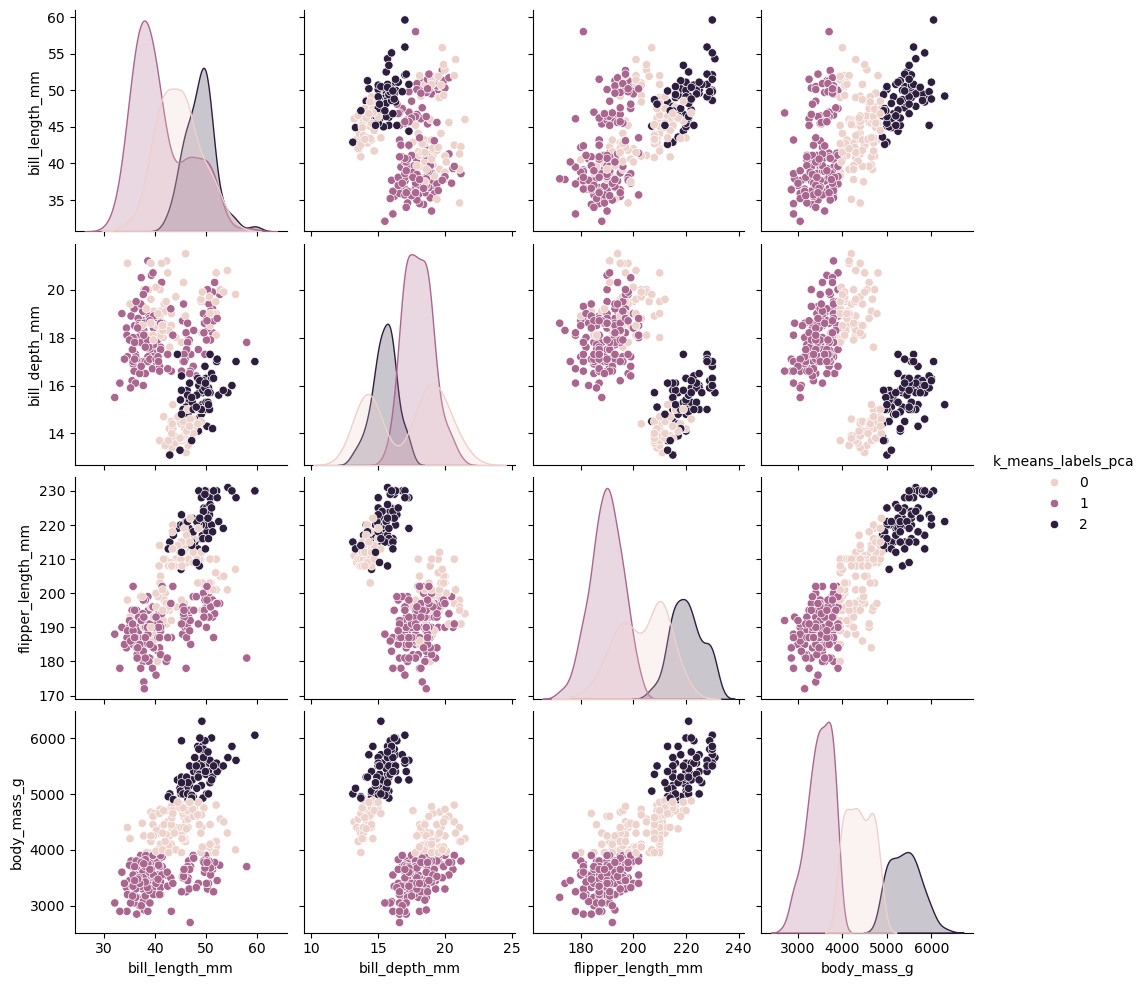

In [35]:
### visualize
sns.pairplot(penguins_df, 
             hue = "k_means_labels_pca",
             vars = [
                 'bill_length_mm',
                 'bill_depth_mm',
                 'flipper_length_mm',
                 'body_mass_g'
                 ]
                 )

Still getting some vertical stripes of clusters. Seems like in this case, reducing the number of variables in the k-means model might be better than doing the PCA

#### Try a different k (tune your hyperparameter)

We can try a bunch of different k values. Let's ignore the labels this time and calculate the silhouette score to see how the different k values perform

In [45]:

### this time we're looking at the silhouette score, so we want to accumulate it into a list
silhouette = []

### make list of k values to loop through
k_list = list(range(2, 8))

### loop through different k values
for k in k_list:

    ### make model with k clusters
    k_means = KMeans(n_clusters = k, n_init = 'auto')

    ### identify the variables to include
    model_vars = (
        penguins_df
        [['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']])

    ### fit the model
    k_means.fit(model_vars)
        
    ### calculate silhouette score and add it to the list we initialized (along with the corresponding k value)
    silhouette.append(silhouette_score(model_vars, k_means.labels_))

### check it out
silhouette

c:\Users\kjsie\anaconda3\envs\earth-analytics-python\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kjsie\anaconda3\envs\earth-analytics-python\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kjsie\anaconda3\envs\earth-analytics-python\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kjsie\anaconda3\envs\earth-analytics-python

[np.float64(0.6076539010738694),
 np.float64(0.44536986529060535),
 np.float64(0.4336133229011464),
 np.float64(0.4096645223956891),
 np.float64(0.403460769767192),
 np.float64(0.40935902654547923)]

<Axes: >

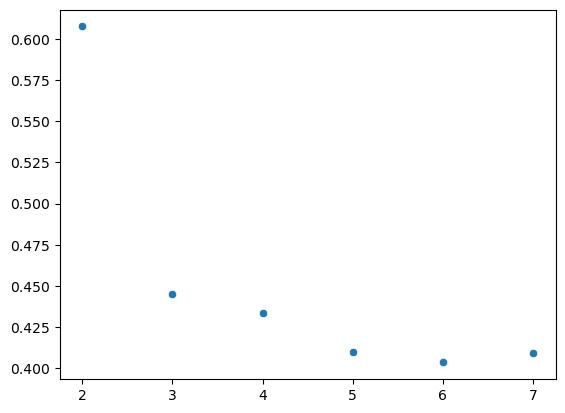

In [46]:
### visualize as a scatterplot
sns.scatterplot(x = k_list, y = silhouette)

We can see a big jump in silhouette score from k = 2 to k = 3. Then we see diminishing returns in the silhouette score as we add additional clusters. There is value to having fewer clusters because they're more likely to be meaningful. 